# Energy Consumption Forecasting Using Time Series Models

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Read Dataset

In [2]:
household_consumption = pd.read_csv("household_power_consumption.txt", sep=";", low_memory=False, na_values=['?'])
household_consumption.head(10)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
5,16/12/2006,17:29:00,3.520,0.522,235.02,15.0,0.0,2.0,17.0
6,16/12/2006,17:30:00,3.702,0.520,235.09,15.8,0.0,1.0,17.0
7,16/12/2006,17:31:00,3.700,0.520,235.22,15.8,0.0,1.0,17.0
8,16/12/2006,17:32:00,3.668,0.510,233.99,15.8,0.0,1.0,17.0
9,16/12/2006,17:33:00,3.662,0.510,233.86,15.8,0.0,2.0,16.0


## Data Cleaning 

### 1. Handle Missing Values

In [3]:
# find the missing values in each column of household_consumption
missing_values = household_consumption.isnull().sum()

print("Missing Values Count in Each Column :\n")
print(missing_values)

Missing Values Count in Each Column :

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


In [4]:
# Calculate the percentage of missing values in each column
missing_percentage = (missing_values / len(household_consumption)) * 100

# Print the missing values percentage for each column
print("Percentage of Missing Values in Each Column:")
print(missing_percentage)

Percentage of Missing Values in Each Column:
Date                     0.000000
Time                     0.000000
Global_active_power      1.251844
Global_reactive_power    1.251844
Voltage                  1.251844
Global_intensity         1.251844
Sub_metering_1           1.251844
Sub_metering_2           1.251844
Sub_metering_3           1.251844
dtype: float64


In [5]:
# Remove rows with missing values
household_consumption_cleaned = household_consumption.dropna()
print("Dataset Shape Before Handle Missing Values :", household_consumption.shape)
print("\nDataset Shape After Handle Missing Values :", household_consumption_cleaned.shape)

Dataset Shape Before Handle Missing Values : (2075259, 9)

Dataset Shape After Handle Missing Values : (2049280, 9)


### 2. Handle Outliers

In [6]:
# Define a Z-score threshold (e.g., 3 or -3 for extreme outliers, significance_level = 0.05)
zScoreThreshold = 3

# Identify outliers for the 'Global_active_power' column
zScores = np.abs(stats.zscore(household_consumption_cleaned['Global_active_power']))
outliersIndices = np.where(zScores > zScoreThreshold)

# Print the number of outliers and their indices
print("Total Number of Outliers in Dataset:", len(outliersIndices[0]))
print("Indices of outliers:", outliersIndices[0])

Total Number of Outliers in Dataset: 36160
Indices of outliers: [      1       2       3 ... 2047047 2047048 2047049]


In [7]:
# Remove rows with outliers
household_consumption_cleaned_no_outliers = household_consumption_cleaned.drop(household_consumption_cleaned.index[outliersIndices[0]])

# Display the shape of the cleaned dataset without outliers
print("Shape of Dataset Without Outliers:", household_consumption_cleaned_no_outliers.shape)

Shape of Dataset Without Outliers: (2013120, 9)


### 3. Hanlde Duplicate Rows

In [8]:
# Check for duplicate rows
duplicateRows = household_consumption_cleaned_no_outliers[household_consumption_cleaned_no_outliers.duplicated(keep=False)]

# Print the number of duplicate rows
print("Number of Duplicate Rows:", len(duplicateRows))

# Display the duplicate rows
if not duplicateRows.empty:
    print("Duplicate Rows: ")
    print(duplicateRows)

Number of Duplicate Rows: 0


### 4. Ensure Appropriate Data Types

In [9]:
# Define the Appropriate DataTypes for Each Column
dataTypes = {
    'Date': 'datetime64[ns]',
    'Time': 'timedelta64[ns]',
    'Global_active_power': 'float64',
    'Global_reactive_power': 'float64',
    'Voltage': 'float64',
    'Global_intensity': 'float64',
    'Sub_metering_1': 'float64',
    'Sub_metering_2': 'float64',
    'Sub_metering_3': 'float64'
}

# Ensure data types match the expected types with date format specified
household_consumption_cleaned_no_outliers['Date'] = pd.to_datetime(household_consumption_cleaned_no_outliers['Date'], format='%d/%m/%Y')

# Convert the 'Time' column from string to timedelta
household_consumption_cleaned_no_outliers['Time'] = pd.to_timedelta(household_consumption_cleaned_no_outliers['Time'])


household_consumption_data = household_consumption_cleaned_no_outliers.astype(dataTypes)

household_consumption_data.dtypes

Date                      datetime64[ns]
Time                     timedelta64[ns]
Global_active_power              float64
Global_reactive_power            float64
Voltage                          float64
Global_intensity                 float64
Sub_metering_1                   float64
Sub_metering_2                   float64
Sub_metering_3                   float64
dtype: object

In [10]:
household_consumption_data.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,0 days 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
4,2006-12-16,0 days 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
5,2006-12-16,0 days 17:29:00,3.520,0.522,235.02,15.0,0.0,2.0,17.0
6,2006-12-16,0 days 17:30:00,3.702,0.520,235.09,15.8,0.0,1.0,17.0
7,2006-12-16,0 days 17:31:00,3.700,0.520,235.22,15.8,0.0,1.0,17.0


## Descriptive Statistics

In [11]:
# Compute descriptive statistics with three decimal points
descriptiveSummary = household_consumption_data.describe().round(3).transpose()
descriptiveSummary

,count,mean,std,min,25%,50%,75%,max
Time,2013120,0 days 11:54:35.110574630,0 days 06:55:44.209193495,0 days 00:00:00,0 days 05:54:00,0 days 11:52:00,0 days 17:52:00,0 days 23:59:00
Global_active_power,2013120.0,1.018,0.903,0.076,0.306,0.57,1.498,4.262
Global_reactive_power,2013120.0,0.122,0.111,0.0,0.048,0.1,0.192,1.274
Voltage,2013120.0,240.927,3.175,223.2,239.1,241.06,242.92,254.15
Global_intensity,2013120.0,4.314,3.777,0.2,1.4,2.6,6.2,19.8
Sub_metering_1,2013120.0,0.769,4.941,0.0,0.0,0.0,0.0,61.0
Sub_metering_2,2013120.0,0.986,4.354,0.0,0.0,0.0,1.0,69.0
Sub_metering_3,2013120.0,6.308,8.389,0.0,0.0,1.0,17.0,31.0


## Sesonality Analysis

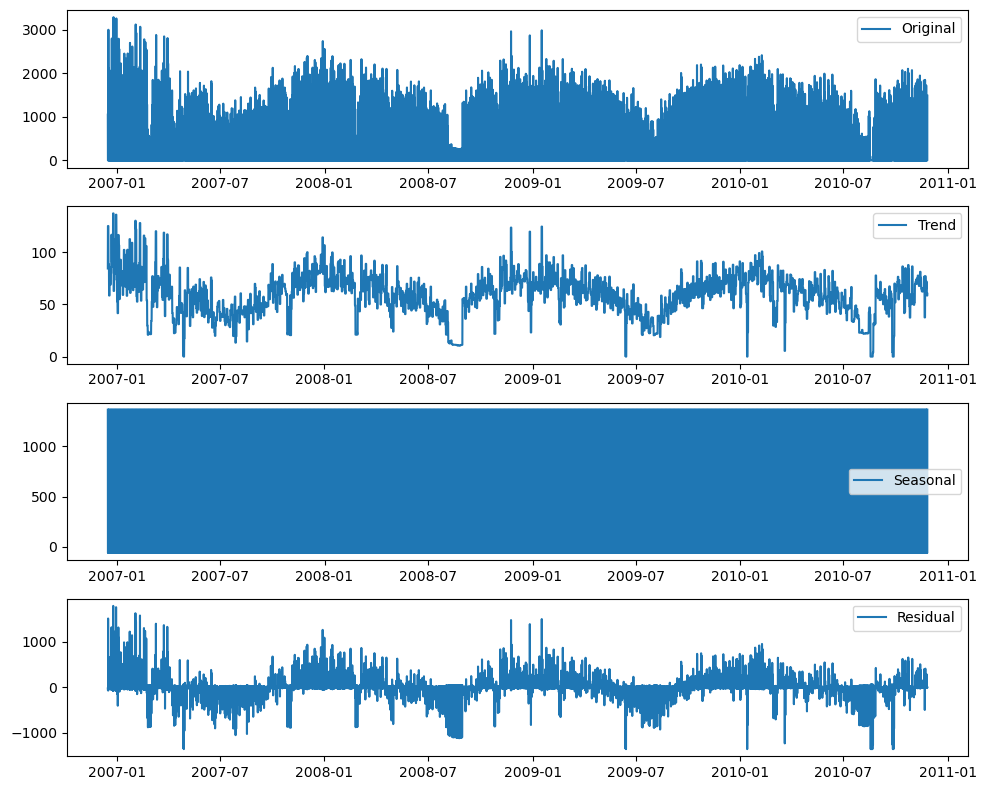

In [12]:
household_consumption_copy = household_consumption_data.copy()
household_consumption_copy['Date'] = pd.to_datetime(household_consumption_copy['Date'], format='%d/%m/%Y')
household_consumption_copy.set_index('Date', inplace=True)

# Seasonal decomposition
dataResampled = household_consumption_copy.resample('60T').sum(numeric_only=True)  # Assuming 60-minute frequency
decomposition = seasonal_decompose(dataResampled['Global_active_power'],
                                   model = 'additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Visualize the components
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(dataResampled['Global_active_power'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

The original data seems to have some fluctuations over time, which could be due to both trend and seasonality.

The trend graph appears to be relatively stable over time, with a slight increase around 2009 and a slight decrease around 2011. This suggests that there might be some long-term increase or decrease in the data.

The Seasonality Graph appears to be relatively consistent over time, with peaks and troughs occurring at regular intervals. This suggests that there might be some pattern in the data that repeats itself at regular intervals.

## Data Preprocessing

### 1. Resample to Hourly Frequency

In [13]:
household_consumption_data.set_index('Date', inplace=True)
resampleData = household_consumption_data.resample('H').sum(numeric_only=True)
resampleData.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date,,,,,,,
2006-12-16 00:00:00,1051.084,30.4,86555.25,4500.2,0.0,254.0,4427.0
2006-12-16 01:00:00,0.000,0.0,0.00,0.0,0.0,0.0,0.0
2006-12-16 02:00:00,0.000,0.0,0.00,0.0,0.0,0.0,0.0
2006-12-16 03:00:00,0.000,0.0,0.00,0.0,0.0,0.0,0.0
2006-12-16 04:00:00,0.000,0.0,0.00,0.0,0.0,0.0,0.0


In [14]:
resampleData.shape

(34585, 7)

### 3. Scalling and Data Splitting 

In [15]:
from sklearn.model_selection import train_test_split

global_active_power = resampleData['Global_active_power'].values

# Normalize btc_close to scale between 0 and 1
min_max_scaler            = MinMaxScaler(feature_range = (0, 1))
global_active_power_sacle = min_max_scaler.fit_transform(global_active_power.reshape(-1, 1))

# Split btc_close_scale into Training and Validation Sets (80/20 split)
train_data, test_data = train_test_split(global_active_power_sacle,
                                        test_size = 0.2,
                                        shuffle   = False)

print("Train Data Shape :", train_data.shape)
print("Test Data Shape :", test_data.shape)

Train Data Shape : (27668, 1)
Test Data Shape : (6917, 1)


### 4. Sequance Generation

In [16]:
def generate_sequance(model_data, sequance_length):
    xx = []
    yy = []
    for i in range(len(model_data) - sequance_length):
        a = model_data[i : i + sequance_length]
        b = model_data[i + sequance_length]
        xx.append(a)
        yy.append(b)
    return np.array(xx), np.array(yy)

In [17]:
sequance_length  = 24  
X_train, y_train = generate_sequance(train_data, sequance_length)
X_test, y_test   = generate_sequance(test_data, sequance_length)

print("Train Data Shape :", X_train.shape, y_train.shape)
print("Test Data Shape :", X_test.shape, y_test.shape)

Train Data Shape : (27644, 24, 1) (27644, 1)
Test Data Shape : (6893, 24, 1) (6893, 1)


### 5. Reshapping 

In [18]:
# Reshape inputs for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], sequance_length, 1) )
X_test  = np.reshape(X_test, (X_test.shape[0], sequance_length, 1) )
print("Train Data Shape :", X_train.shape)
print("Test Data Shape :", X_test.shape)

Train Data Shape : (27644, 24, 1)
Test Data Shape : (6893, 24, 1)


## Long Short-Term Memory (LSTM) Model

In [19]:
LSTM_Model = keras.Sequential()

# Add the first LSTM layer with dropout
LSTM_Model.add(layers.LSTM(100, activation='relu',
                           return_sequences=True,
                           input_shape = (X_train.shape[1], 1)))
LSTM_Model.add(layers.Dropout(0.6))

# Add the second LSTM layers with dropout
LSTM_Model.add(layers.LSTM(50, 
                           activation='relu',
                           return_sequences=True))
LSTM_Model.add(layers.Dropout(0.4))
LSTM_Model.add(layers.Dense(64))

# Add the third LSTM layers with dropout
LSTM_Model.add(layers.LSTM(25, activation='relu'))
LSTM_Model.add(layers.Dropout(0.2))
# Add a dense output layer with a single neuron for regression
LSTM_Model.add(layers.Dense(1))

In [20]:
# Compile the model
LSTM_Model.compile(optimizer='adam',
                   loss='mean_squared_error',
                   metrics=['accuracy'])

In [21]:
# Define early stopping and model checkpoint callbacks
earlyStopping   = EarlyStopping(monitor  ='val_loss',
                                 patience = 10,
                                 restore_best_weights = True)

modelCheckpoint = ModelCheckpoint('best_LSTM_Model.h5',
                                  save_best_only = True)

In [23]:
# Train the model
LSTM_History = LSTM_Model.fit(X_train,
                              y_train,
                              batch_size      = 64,
                              epochs          = 50,
                              validation_data = (X_test, y_test),
                              callbacks       = [earlyStopping, modelCheckpoint],
                              shuffle         = False,
                              verbose         = 1)

Epoch 1/50
432/432 [==============================] - 31s 62ms/step - loss: 0.0059 - accuracy: 0.9584 - val_loss: 0.0024 - val_accuracy: 0.9591
Epoch 2/50
  2/432 [..............................] - ETA: 26s - loss: 0.0076 - accuracy: 0.9531

C:\Users\asadm\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


432/432 [==============================] - 27s 63ms/step - loss: 0.0011 - accuracy: 0.9585 - val_loss: 0.0020 - val_accuracy: 0.9589
Epoch 3/50
432/432 [==============================] - 29s 68ms/step - loss: 7.8129e-04 - accuracy: 0.9585 - val_loss: 0.0016 - val_accuracy: 0.9589
Epoch 4/50
432/432 [==============================] - 28s 66ms/step - loss: 7.6137e-04 - accuracy: 0.9584 - val_loss: 0.0011 - val_accuracy: 0.9589
Epoch 5/50
432/432 [==============================] - 28s 64ms/step - loss: 0.0707 - accuracy: 0.9584 - val_loss: 0.0074 - val_accuracy: 0.9591
Epoch 6/50
432/432 [==============================] - 27s 63ms/step - loss: 0.0027 - accuracy: 0.9584 - val_loss: 0.0011 - val_accuracy: 0.9589
Epoch 7/50
432/432 [==============================] - 30s 69ms/step - loss: 9.5990e-04 - accuracy: 0.9585 - val_loss: 0.0013 - val_accuracy: 0.9589
Epoch 8/50
432/432 [==============================] - 34s 79ms/step - loss: 8.5466e-04 - accuracy: 0.9585 - val_loss: 0.0014 - val_accu

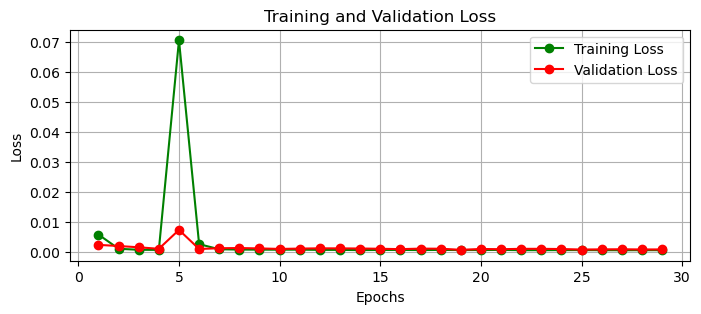

<Figure size 640x480 with 0 Axes>

In [26]:
epochs = range(1, len(LSTM_History.history['loss']) + 1)

# Plot the training and validation loss
plt.figure(figsize=(8, 3))
plt.plot(epochs, LSTM_History.history['loss'], 'g', label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, LSTM_History.history['val_loss'], 'r', label='Validation Loss', marker='o', linestyle='-')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.savefig('lstm-loss.png')

In [54]:
# Load the best model from the checkpoint
LSTMbestModel = keras.models.load_model('best_LSTM_Model.h5')

# Make predictions on the training and validation sets
LSTMtrainingPredictions    = LSTMbestModel.predict(X_train)
LSTMvalidationPredictions  = LSTMbestModel.predict(X_test)

# Inverse transform the scaled predictions to the original scale
LSTMtrainingPredictions   = min_max_scaler.inverse_transform(LSTMtrainingPredictions)
LSTMvalidationPredictions = min_max_scaler.inverse_transform(LSTMvalidationPredictions)
lstm_yTrain               = min_max_scaler.inverse_transform(y_train)
lstm_yTest                = min_max_scaler.inverse_transform(y_test)

LSTM_MSE_Training  = mean_squared_error(lstm_yTrain, LSTMtrainingPredictions)
LSTM_RMSE_Training = np.sqrt(LSTM_MSE_Training)
LSTM_MAE_Training  = mean_absolute_error(lstm_yTrain, LSTMtrainingPredictions)
LSTM_R2_Training   = r2_score(lstm_yTrain, LSTMtrainingPredictions)

# Calculate MSE, RMSE, MAE, and R2 for the validation set
LSTM_MSE_Validation  = mean_squared_error(lstm_yTest, LSTMvalidationPredictions)
LSTM_RMSE_Validation = np.sqrt(LSTM_MSE_Validation)
LSTM_MAE_Validation  = mean_absolute_error(lstm_yTest, LSTMvalidationPredictions)
LSTM_R2_Validation   = r2_score(lstm_yTest, LSTMvalidationPredictions)

# Print the metrics for training and validation sets
print("LSTM Training Set Metrics:")
print(f"MSE: {LSTM_MSE_Training:.4f}")
print(f"RMSE: {LSTM_RMSE_Training:.4f}")
print(f"MAE: {LSTM_MAE_Training:.4f}")
print(f"R2: {LSTM_R2_Training:.4f}")

print("\nLSTM Validation Set Metrics:")
print(f"MSE: {LSTM_MSE_Validation:.4f}")
print(f"RMSE: {LSTM_RMSE_Validation:.4f}")
print(f"MAE: {LSTM_MAE_Validation:.4f}")
print(f"R2: {LSTM_R2_Validation:.4f}")

216/216 [==============================] - 3s 13ms/step
LSTM Training Set Metrics:
MSE: 9237.4556
RMSE: 96.1117
MAE: 19.0191
R2: 0.9013

LSTM Validation Set Metrics:
MSE: 8461.6164
RMSE: 91.9870
MAE: 17.8206
R2: 0.8938


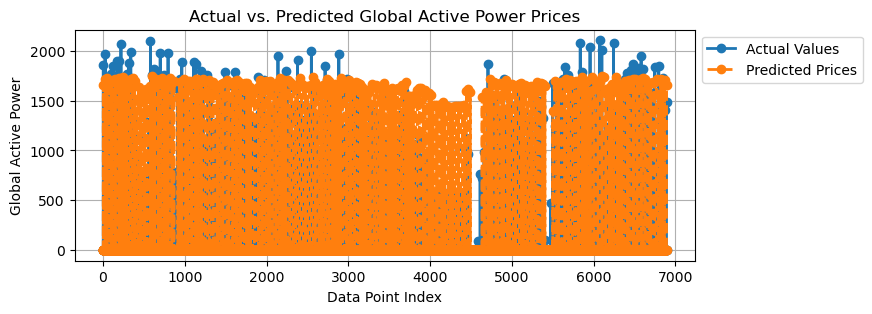

<Figure size 640x480 with 0 Axes>

In [34]:
plt.figure(figsize=(8, 3))
plt.plot(lstm_yTest[:,0], label='Actual Values', marker='o', linewidth = 2)
plt.plot(LSTMvalidationPredictions[:, 0], label='Predicted Prices', linestyle='--', marker='o', linewidth = 2)
plt.xlabel('Data Point Index')
plt.ylabel('Global Active Power')
plt.title('Actual vs. Predicted Global Active Power Prices')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True)
plt.show()

plt.savefig('lstm-predict.png')

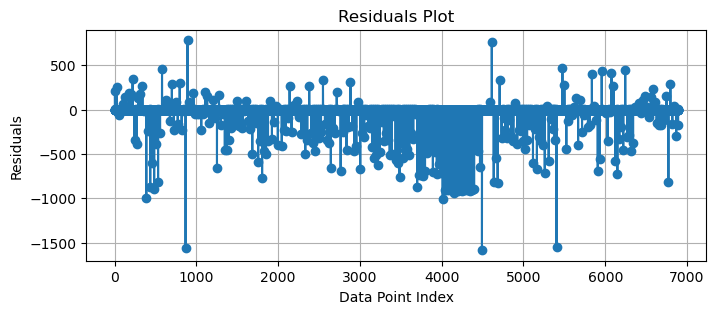

<Figure size 640x480 with 0 Axes>

In [39]:
lstm_residuals = lstm_yTest[:, 0] - LSTMvalidationPredictions[:, 0]
plt.figure(figsize=(8, 3))
plt.plot(lstm_residuals, marker='o')
plt.xlabel('Data Point Index')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True)
plt.show()

plt.savefig('lstm_residuals.png')

## Gated Recurrent Unit (GRU) Model

In [40]:
GRU_Model = keras.Sequential()
# Add the first LSTM layer with dropout
GRU_Model.add(layers.GRU(100, 
                         activation = 'relu',
                         return_sequences = True,
                         input_shape=(X_train.shape[1], 1)))
GRU_Model.add(layers.Dropout(0.6))

# Add the second LSTM layers with dropout
GRU_Model.add(layers.GRU(50, 
                         activation = 'relu',
                         return_sequences = True))
GRU_Model.add(layers.Dropout(0.4))
GRU_Model.add(layers.Dense(64))

# Add the third LSTM layers with dropout
GRU_Model.add(layers.GRU(25, activation = 'relu'))
GRU_Model.add(layers.Dropout(0.2))
# Add a dense output layer with a single neuron for regression
GRU_Model.add(layers.Dense(1))

In [41]:
# Compile the model
GRU_Model.compile(optimizer='adam',
                   loss='mean_squared_error',
                   metrics=['accuracy'])

In [42]:
# Define early stopping and model checkpoint callbacks
earlyStopping   = EarlyStopping(monitor  ='val_loss',
                                 patience = 10,
                                 restore_best_weights = True)

modelCheckpoint = ModelCheckpoint('best_GRU_Model.h5',
                                  save_best_only = True)

In [43]:
# Train the model
GRU_History = GRU_Model.fit(X_train,
                              y_train,
                              batch_size      = 64,
                              epochs          = 50,
                              validation_data = (X_test, y_test),
                              callbacks       = [earlyStopping, modelCheckpoint],
                              shuffle         = False,
                              verbose         = 1)

Epoch 1/50
432/432 [==============================] - 25s 49ms/step - loss: 0.0081 - accuracy: 0.9584 - val_loss: 0.0064 - val_accuracy: 0.9591
Epoch 2/50
  3/432 [..............................] - ETA: 19s - loss: 0.0136 - accuracy: 0.9583

C:\Users\asadm\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


432/432 [==============================] - 21s 50ms/step - loss: 0.0021 - accuracy: 0.9584 - val_loss: 0.0023 - val_accuracy: 0.9589
Epoch 3/50
432/432 [==============================] - 22s 51ms/step - loss: 9.4417e-04 - accuracy: 0.9584 - val_loss: 0.0010 - val_accuracy: 0.9589
Epoch 4/50
432/432 [==============================] - 25s 58ms/step - loss: 8.6184e-04 - accuracy: 0.9584 - val_loss: 0.0013 - val_accuracy: 0.9589
Epoch 5/50
432/432 [==============================] - 25s 58ms/step - loss: 7.8720e-04 - accuracy: 0.9584 - val_loss: 0.0014 - val_accuracy: 0.9589
Epoch 6/50
432/432 [==============================] - 27s 61ms/step - loss: 8.1221e-04 - accuracy: 0.9585 - val_loss: 0.0014 - val_accuracy: 0.9589
Epoch 7/50
432/432 [==============================] - 25s 59ms/step - loss: 9.1735e-04 - accuracy: 0.9584 - val_loss: 0.0013 - val_accuracy: 0.9589
Epoch 8/50
432/432 [==============================] - 26s 60ms/step - loss: 8.5073e-04 - accuracy: 0.9584 - val_loss: 0.0012 - 

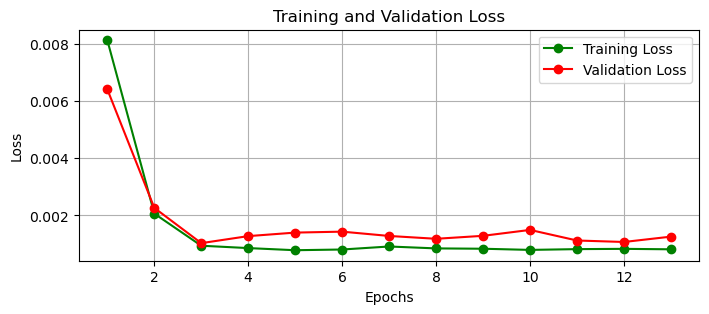

<Figure size 640x480 with 0 Axes>

In [44]:
epochs = range(1, len(GRU_History.history['loss']) + 1)

# Plot the training and validation loss
plt.figure(figsize=(8, 3))
plt.plot(epochs, GRU_History.history['loss'], 'g', label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, GRU_History.history['val_loss'], 'r', label='Validation Loss', marker='o', linestyle='-')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.savefig('gru-loss.png')

In [55]:
# Load the best model from the checkpoint
GRUbestModel = keras.models.load_model('best_GRU_Model.h5')

# Make predictions on the training and validation sets
GRUtrainingPredictions    = GRUbestModel.predict(X_train)
GRUvalidationPredictions  = GRUbestModel.predict(X_test)

# Inverse transform the scaled predictions to the original scale
GRUtrainingPredictions   = min_max_scaler.inverse_transform(GRUtrainingPredictions)
GRUvalidationPredictions = min_max_scaler.inverse_transform(GRUvalidationPredictions)
GRU_yTrain               = min_max_scaler.inverse_transform(y_train)
GRU_yTest                = min_max_scaler.inverse_transform(y_test)

GRU_MSE_Training  = mean_squared_error(GRU_yTrain, GRUtrainingPredictions)
GRU_RMSE_Training = np.sqrt(GRU_MSE_Training)
GRU_MAE_Training  = mean_absolute_error(GRU_yTrain, GRUtrainingPredictions)
GRU_R2_Training   = r2_score(GRU_yTrain, GRUtrainingPredictions)

# Calculate MSE, RMSE, MAE, and R2 for the validation set
GRU_MSE_Validation  = mean_squared_error(GRU_yTest, GRUvalidationPredictions)
GRU_RMSE_Validation = np.sqrt(GRU_MSE_Validation)
GRU_MAE_Validation  = mean_absolute_error(GRU_yTest, GRUvalidationPredictions)
GRU_R2_Validation   = r2_score(GRU_yTest, GRUvalidationPredictions)

# Print the metrics for training and validation sets
print("GRU Training Set Metrics:")
print(f"MSE: {GRU_MSE_Training:.4f}")
print(f"RMSE: {GRU_RMSE_Training:.4f}")
print(f"MAE: {GRU_MAE_Training:.4f}")
print(f"R2: {GRU_R2_Training:.4f}")

print("\n GRU Validation Set Metrics:")
print(f"MSE: {GRU_MSE_Validation:.4f}")
print(f"RMSE: {GRU_RMSE_Validation:.4f}")
print(f"MAE: {GRU_MAE_Validation:.4f}")
print(f"R2: {GRU_R2_Validation:.4f}")

216/216 [==============================] - 2s 9ms/step
GRU Training Set Metrics:
MSE: 11736.7589
RMSE: 108.3363
MAE: 29.3226
R2: 0.8746

 GRU Validation Set Metrics:
MSE: 11220.3342
RMSE: 105.9261
MAE: 28.7944
R2: 0.8592


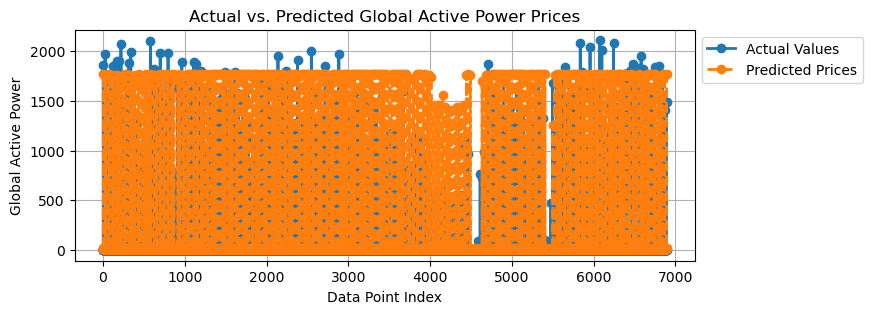

<Figure size 640x480 with 0 Axes>

In [46]:
plt.figure(figsize=(8, 3))
plt.plot(GRU_yTest[:,0], label='Actual Values', marker='o', linewidth = 2)
plt.plot(GRUvalidationPredictions[:, 0], label='Predicted Prices', linestyle='--', marker='o', linewidth = 2)
plt.xlabel('Data Point Index')
plt.ylabel('Global Active Power')
plt.title('Actual vs. Predicted Global Active Power Prices')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True)
plt.show()

plt.savefig('gru-predict.png')

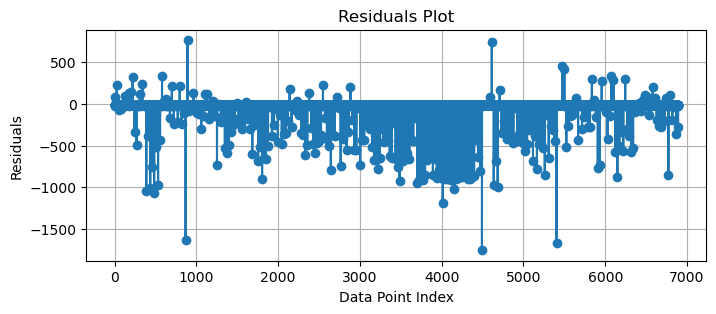

<Figure size 640x480 with 0 Axes>

In [47]:
gru_residuals = GRU_yTest[:, 0] - GRUvalidationPredictions[:, 0]
plt.figure(figsize=(8, 3))
plt.plot(gru_residuals, marker='o')
plt.xlabel('Data Point Index')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True)
plt.show()

plt.savefig('gru_residuals.png')

# Model Comparison

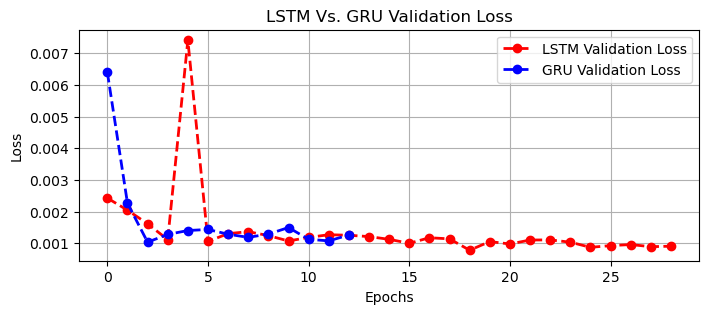

In [49]:
# Plot the training and validation loss
plt.figure(figsize=(8, 3))
plt.plot(LSTM_History.history['val_loss'], 'r', label='LSTM Validation Loss', linestyle='--', marker='o', linewidth = 2)
plt.plot(GRU_History.history['val_loss'], 'b', label='GRU Validation Loss', linestyle='--', marker='o', linewidth = 2)
plt.title('LSTM Vs. GRU Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

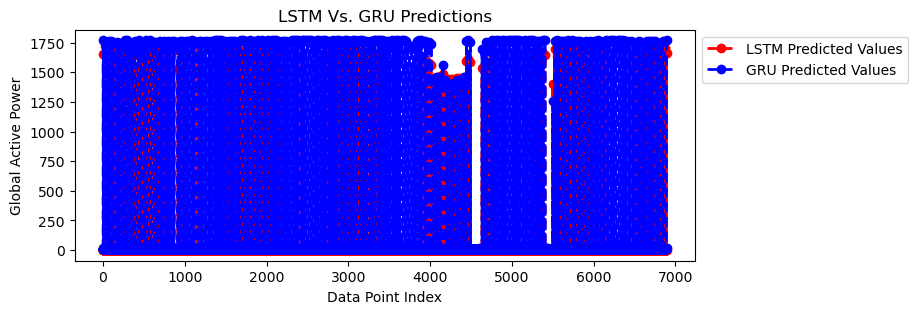

In [53]:
plt.figure(figsize=(8,3))
plt.plot(LSTMvalidationPredictions, color = 'red', label = 'LSTM Predicted Values', linestyle='--', marker='o', linewidth = 2)
plt.plot(GRUvalidationPredictions, color = 'blue', label = 'GRU Predicted Values',linestyle='--',  marker='o',linewidth = 2)

plt.title('LSTM Vs. GRU Predictions')
plt.xlabel('Data Point Index')
plt.ylabel('Global Active Power')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()